In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import *
from datetime import datetime

plt.style.use('ggplot')

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [3]:
metadata = MetaData()
connection = engine.connect()

In [4]:
measurement = Table('measurement', metadata, autoload=True, autoload_with=engine)
station = Table('station', metadata, autoload=True, autoload_with=engine)

In [5]:
prcp_sum = func.sum(measurement.columns.prcp).label('precipitation')
stmt = select([measurement.columns.date, prcp_sum])
stmt = stmt.group_by(measurement.columns.date)
stmt = stmt.where(measurement.columns.date > '2016-08-31')
print(stmt)

SELECT measurement.date, sum(measurement.prcp) AS precipitation 
FROM measurement 
WHERE measurement.date > :date_1 GROUP BY measurement.date


In [6]:
results = connection.execute(stmt).fetchall()

In [7]:
df = pd.DataFrame(results)
df.columns = results[0].keys()

In [8]:
time_series = []
for i in range(len(df)):
        date = datetime.strptime(df['date'][i], "%Y-%m-%d")
        time_series.append(date)

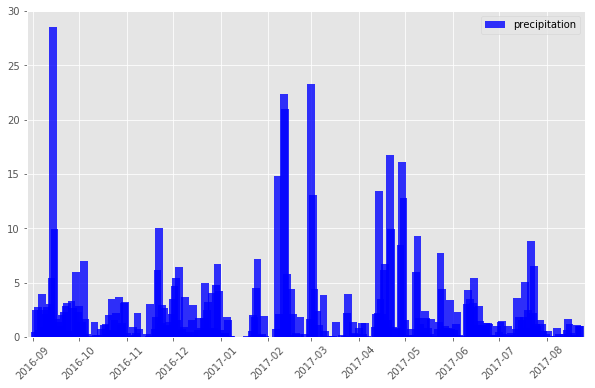

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(time_series, df['precipitation'], width=5, label='precipitation',
       color='blue', alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.xlim(pd.Timestamp('2016-8-28'), pd.Timestamp('2017-8-26'))
plt.show()

In [10]:
df['precipitation'].describe()

count    357.000000
mean       0.945294
std        1.731066
min        0.000000
25%        0.050000
50%        0.390000
75%        1.070000
max       14.280000
Name: precipitation, dtype: float64

In [10]:
stmt = select([func.count(station.columns.station.distinct())])
distinct_station_count = connection.execute(stmt).scalar()
print(distinct_station_count)

9


In [11]:
ob_count = func.count(measurement.columns.prcp).label('observation_count')
stmt = select([measurement.columns.station, ob_count])
stmt = stmt.group_by(measurement.columns.station)
rev_stmt = stmt.order_by(desc(ob_count))

print(rev_stmt)

SELECT measurement.station, count(measurement.prcp) AS observation_count 
FROM measurement GROUP BY measurement.station ORDER BY observation_count DESC


In [12]:
# Execute the statement
results = connection.execute(rev_stmt).fetchall()

In [13]:
# print the results
for result in results:
    print(result)

print("----------")
print(f"The most active station is {results[0][0]}, with {results[0][1]} of observations.")

('USC00519281', 5544)
('USC00519397', 5448)
('USC00513117', 5418)
('USC00519523', 5338)
('USC00516128', 5224)
('USC00514830', 4404)
('USC00511918', 3958)
('USC00517948', 2744)
('USC00518838', 1022)
----------
The most active station is USC00519281, with 5544 of observations.


## Design a query to retrieve the last 12 months of temperature observation data (tobs)

In [14]:
stmt = select([measurement.columns.tobs])
stmt = stmt.where(measurement.columns.station == "USC00519281")
stmt = stmt.where(measurement.columns.date > '2016-08-31')
print(stmt)

SELECT measurement.tobs 
FROM measurement 
WHERE measurement.station = :station_1 AND measurement.date > :date_1


In [15]:
results = connection.execute(stmt).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()

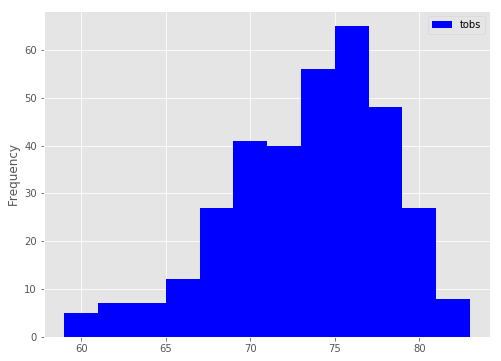

In [18]:
df.plot.hist(bins=12, figsize=(8,6), color='blue')
plt.show()

In [17]:
def calc_temps(start_date, end_date):
    tobs_avg = func.avg(measurement.columns.tobs).label('tobs_avg')
    stmt = select([tobs_avg])
    stmt = stmt.where(measurement.columns.date > start_date)
    stmt = stmt.where(measurement.columns.date < end_date)
    stmt = stmt.group_by(measurement.columns.date)
    results = connection.execute(stmt).fetchall()
    df = pd.DataFrame(results)
    df.columns = results[0].keys()
    mean_tobs = df['tobs_avg'].mean()
    max_tobs = df['tobs_avg'].max()
    min_tobs = df['tobs_avg'].min()
    diff_tobs = max_tobs - min_tobs
    return df

In [18]:
df = calc_temps('2017-01-01', '2018-01-01')

In [19]:
mean_tobs = df['tobs_avg'].mean()
max_tobs = df['tobs_avg'].max()
min_tobs = df['tobs_avg'].min()
diff_tobs = max_tobs - min_tobs

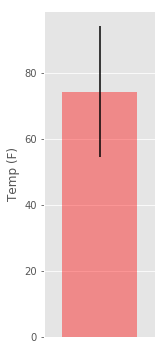

In [20]:
fig = plt.figure(figsize=(2,6))
plt.bar(0, mean_tobs, color='red', width=0.2, yerr = diff_tobs, alpha=0.4)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.xlim(-0.15, 0.15)
plt.show()

In [23]:
def daily_normals(date):
    tobs_avg = func.avg(measurement.columns.tobs).label('tobs_avg')
    tobs_max = func.max(measurement.columns.tobs).label('tobs_max')
    tobs_min = func.min(measurement.columns.tobs).label('tobs_min')
    stmt = select([tobs_avg, tobs_max, tobs_min])
    stmt = stmt.where(measurement.columns.date.like(f"%{date}"))
    results = connection.execute(stmt).fetchall()
    mean, max, min = results[0]
    
    return mean, max, min

In [24]:
date_list = ["01-01", "01-02", "01-03", "01-04", "01-05", "01-06", "01-07"]

In [25]:
mean_list = []
max_list = []
min_list = []
for date in date_list:
    mean, max, min = daily_normals(date)
    mean_list.append(mean)
    max_list.append(max)
    min_list.append(min)

In [26]:
df = pd.DataFrame({
    "date": date_list,
    "tavg": mean_list,
    "tmax": max_list,
    "tmin": min_list
})

In [27]:
df = df.set_index('date')

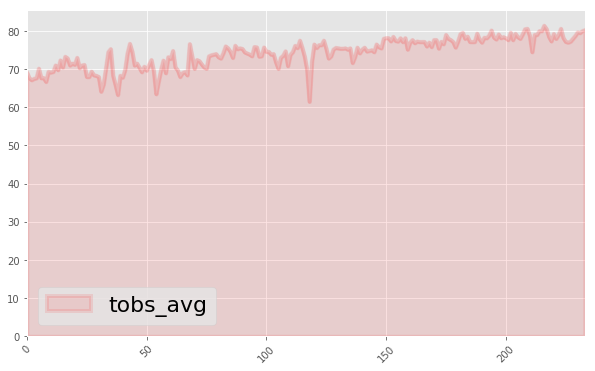

In [23]:
df.plot.area(figsize=(10,6),stacked=False, alpha=0.1, linewidth=4,
             color=['red', 'brown','blue'])
plt.xticks(rotation=45)
plt.legend(fontsize = 22)
plt.show()